### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [2]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2024-11-17 20:44:55--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  4.57MB/s    in 0.2s    

2024-11-17 20:44:56 (4.57 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2024-11-17 20:44:56--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.1

### Чтение последовательностей

In [3]:
%%capture
!pip install bio

In [4]:
from Bio import SeqIO, Seq
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("./GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('./GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
    gb = record

In [5]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
    feature = gb.features[i]
    fseq = feature.extract(seq)

    end = feature.location.start

    if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
        cod.append(fseq.__str__())

        if len(seq[start:end]) != 0:
            ncod.append(seq[start:end].__str__())

        start = feature.location.end

### Начальные вероятности

In [6]:
def seq_probs(seq):
    return np.array([
            seq.count('T'), seq.count('C'),
            seq.count('A'), seq.count('G')
        ]) / len(seq)

def cod_probs(seq):
    res = []
    for i in range(3):
        res.append(seq_probs(seq[i::3]))
    return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
    table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
    return table1

In [7]:
t1 = make_table1(cod, ncod)
t1

pos1      pos2      pos3        nc
T  0.181143  0.296068  0.315043  0.273024
C  0.206706  0.227065  0.233173  0.228923
A  0.256916  0.302111  0.238480  0.276478
G  0.355236  0.174755  0.213304  0.221574

### Вероятности перехода


In [8]:
def cod_dprobs(seqs):
    dcounts = dict(
        zip([1, 2, 3],
                [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
        )
    for seq in seqs:
        for i in range(1, len(seq)):
            dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
    return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
        for i in range(1, len(seq)):
            dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
    for pos in dcounts:
        nuc_groups = dict(zip('TCAG', [0] * 4))
        for dup in dcounts[pos]:
            nuc_groups[dup[0]] += dcounts[pos][dup]
        for dup in dcounts[pos]:
            dcounts[pos][dup] /= nuc_groups[dup[0]]
    return dcounts

def make_table2(cod_seqs, ncod_seqs):
    table2 = pd.DataFrame(cod_dprobs(cod_seqs))
    table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
    table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
    table2.index = [prob_notation(idx) for idx in table2.index.values]
    return table2

def prob_notation(st):
    return st[1] + '|' + st[0]

In [9]:
t2 = make_table2(cod, ncod)
t2

pos1      pos2      pos3        nc
T|T  0.185482  0.497862  0.316308  0.318271
C|T  0.189688  0.199483  0.179891  0.208911
A|T  0.249131  0.172440  0.221458  0.243934
G|T  0.375698  0.130215  0.282343  0.228884
T|C  0.185235  0.248571  0.269872  0.252402
C|C  0.156213  0.197930  0.244217  0.214059
A|C  0.276197  0.315174  0.244461  0.286765
G|C  0.382355  0.238325  0.241449  0.246775
T|A  0.179889  0.334011  0.307774  0.270128
C|A  0.194131  0.213909  0.193560  0.205302
A|A  0.263065  0.327772  0.331071  0.320306
G|A  0.362915  0.124307  0.167594  0.204264
T|G  0.174164  0.193366  0.384157  0.242334
C|G  0.304052  0.267599  0.377576  0.299712
A|G  0.230084  0.342074  0.099476  0.250839
G|G  0.291700  0.196961  0.138790  0.207115

## Aлгоритм

При написании кода я использовала интернет, ИИ-ресурсы и [тетраку с семинара](https://colab.research.google.com/drive/1hIxAL6NfVUmT3crwuZCu2Xzre8jrNkws?usp=sharing).

### Ядро

#### Импорт библиотек

In [14]:
from tqdm.notebook import tqdm
from warnings import filterwarnings
import time
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
import os

filterwarnings(action='ignore', category=RuntimeWarning)
n_cpu = os.cpu_count()

#### _Probabilities

_Probabilities - класс предназначенный для вычисления и хранения вероятностных таблиц, основанных на последовательностях ДНК или РНК.

In [15]:
class _Probabilities():
    def __init__(self):
        super().__init__()
        self.initialized=False
        self.t1 = None
        self.t2 = None


###########################################################################
###########################################################################
# Calculating probability tables

    def _seq_probs(self, seq):
        if(len(seq)==0):
            return np.zeros((4))
        return np.array([
            seq.count('T'), seq.count('C'),
            seq.count('A'), seq.count('G')
          ]) / len(seq)


    def _cod_probs(self, seq):
        res = []
        for i in range(3):
              res.append(self._seq_probs(seq[i::3]))
        return np.array(res)


    def _cod_dprobs(self, seqs):
        dcounts = dict(
          zip([1, 2, 3],
              [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                        [0] * 16)) for i in range(3)])
          )
        for seq in seqs:
            for i in range(1, len(seq)):
                if(seq[i-1]=='N' or seq[i]=='N'): continue
                dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
        return self._get_probs(dcounts)


    def _ncod_dprobs(self, seqs):
        dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                        [0] * 16))
        for seq in seqs:
            for i in range(1, len(seq)):
                if(seq[i-1]=='N' or seq[i]=='N'): continue
                dcounts[seq[i-1:i+1]] += 1
        return self._get_probs({0: dcounts})[0]


    def _get_probs(self, dcounts):
        for pos in dcounts:
            nuc_groups = dict(zip('TCAG', [0] * 4))
            for dup in dcounts[pos]:
                nuc_groups[dup[0]] += dcounts[pos][dup]
            for dup in dcounts[pos]:
                if(nuc_groups[dup[0]]>0):
                    dcounts[pos][dup] /= nuc_groups[dup[0]]
        return dcounts


    def _prob_notation(self, st):
        return st[1] + '|' + st[0]


    def make_table1(self, cod_seqs:np.ndarray, ncod_seqs:np.ndarray) -> pd.DataFrame:
        table1 = pd.DataFrame(np.vstack((self._cod_probs(''.join(cod_seqs)), self._seq_probs(''.join(ncod_seqs)))).T,
                            index=['T', 'C', 'A', 'G'],
                            columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
        return table1


    def make_table2(self, cod_seqs:np.ndarray, ncod_seqs:np.ndarray) -> pd.DataFrame:
        table2 = pd.DataFrame(self._cod_dprobs(cod_seqs))
        table2[4] = pd.Series(self._ncod_dprobs(ncod_seqs))
        table2.rename(columns=dict(zip(np.arange(1, 5),
                                      [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                      inplace=True)
        table2.index = [self._prob_notation(idx) for idx in table2.index.values]
        return table2


    def _recalc_tables(self, seq:Seq.Seq, cod_rfs, __call_from_init:bool=False) -> None:
        seq_len=self.seq_len
        ncod_rfs = self._calc_ncod_rfs(cod_rfs)
        cod_seqs, ncod_seqs = self._rfs2seqs(seq, cod_rfs), self._rfs2seqs(seq, ncod_rfs)

        if(__call_from_init and self.t1 is not None and self.t2 is not None): return
        if(__call_from_init):
            cod_seqs = self._rfs2seqs(seq, self._calc_long_orfs(900))
        self.t1 = self.make_table1(cod_seqs, ncod_seqs)
        self.t2 = self.make_table2(cod_seqs, ncod_seqs)


    def _init_tables(self, seq: Seq.Seq, both_strands:bool=True) -> None:
        orfs = (self._get_orfs_both_strands(seq) if both_strands else self._get_orfs_single_strand(seq, True))
        cod_rframes  = self._calc_long_orfs()

        self._recalc_tables(seq, cod_rframes, True)
        self.initialized = True


    def set_tables(self, t1:pd.DataFrame, t2:pd.DataFrame):
        self.t1 = t1.copy()
        self.t2 = t2.copy()


###########################################################################
###########################################################################
# Calculating sequence-related probabilities

    def _seq_cod_log_prob(self, seq:Seq.Seq, frame=1, eps:float=1e-8, N_prob:float=0.3): # log(P(seq|cod_frame))
        if len(seq) == 0:
            print('No sequence')
            return None

        if frame not in [1, 2, 3]:
            print('No such frame')
            return None

        prev_nuc = seq[0]

        log_prob= (np.log(N_prob) if prev_nuc=='N' else np.log(self.t1["pos{0}".format(frame)][prev_nuc]))
        for i, nuc in enumerate(seq[1:]):
            pos = "pos{0}".format(1+((i+frame)%3))
            pair = '{}|{}'.format(nuc, prev_nuc)
            if (nuc!='N' and prev_nuc!='N'):
                log_prob += np.log(self.t2[pos][pair])
            if(nuc=='N'): log_prob += np.log(N_prob)
            prev_nuc = nuc
        return log_prob


    def _cond_probs(self, seq_cond_log_probs:tuple, aprior_probs:tuple=(0.25, 0.25, 0.25, 0.25), eps:float=1e-8) -> tuple: # P(type[i]|seq) tuple, i=1..4
        type_log_probs=np.array([0,0,0,0])
        aprior_log_probs = np.log(aprior_probs)

        numer = seq_cond_log_probs + aprior_log_probs
        denom = np.log(np.sum(np.exp(seq_cond_log_probs + aprior_log_probs)))
        type_log_probs = numer - denom
        return np.exp(type_log_probs)


    def _ncod_log_prob(self, seq:Seq.Seq, N_prob:float=0.3) -> float: # log(P(seq|ncod))
        prev_nuc=seq[0]
        log_prob = (np.log(1-N_prob) if prev_nuc=='N' else np.log(self.t1['nc'][prev_nuc]))

        for i,nuc in enumerate(seq[1:]):
            pair="{}|{}".format(nuc, prev_nuc)
            if (nuc!='N' and prev_nuc!='N'):
                log_prob += np.log(self.t2['nc'][pair])
            if(nuc=='N'): log_prob += np.log(1-N_prob)
            prev_nuc = nuc
        return log_prob


    def _get_cod_probs(self, seq:Seq.Seq) -> np.ndarray:
        prob1 = self._seq_cod_log_prob(seq, frame=1)
        prob2 = self._seq_cod_log_prob(seq, frame=2)
        prob3 = self._seq_cod_log_prob(seq, frame=3)
        probnc = self._ncod_log_prob(seq)
        return self._cond_probs((prob1, prob2, prob3, probnc))


    def _get_pos_probs_par_helper(self, subseq, start, stop, step, window):
        tmp=[]
        with Pool(n_cpu) as p:
            tmp=p.map(self._get_cod_probs, [subseq[i:i+window] for i in range(0, stop-start, step)])
        return tmp


    def get_pos_probs(self, seq, start:int=0, stop:int=3000, step:int=12, window:int=96, both_strands:bool=True) -> np.ndarray:
        pos_probs = []
        subseq = seq[start:stop]

        # for i in range(0, stop-start, step):
        #     pos_probs.append(self._get_cod_probs(subseq[i:i+window])) #deprecated
        pos_probs = self._get_pos_probs_par_helper(subseq,start,stop,step,window)

        pos_probs = np.array(pos_probs)

        if(both_strands==True):
            neg_pos_probs=[]
            # for i in range(0, stop-start, step):
            #     neg_pos_probs.append(self._get_cod_probs(subseq.reverse_complement()[i:i+window])) #deprecated
            neg_pos_probs = self._get_pos_probs_par_helper(subseq.reverse_complement(),start,stop,step,window)

            neg_pos_probs = np.array(neg_pos_probs)
            pos_probs = np.hstack((pos_probs, neg_pos_probs))
        self.probs = pos_probs.copy()
        return pos_probs

#### _GeneMarkBase
_GeneMarkBase класс, который наследуется от класса _Probabilities (описанного в предыдущих вопросах) и предназначен для поиска и анализа открытых рамок считывания (ORF) в нуклеотидных последовательностях.

In [16]:
class _GeneMarkBase(_Probabilities):
    def __init__(self, tol:float=1e-4):
        super().__init__()
        self.tol=tol
        self.last_cod_rfs=None
        self._last_genes=None

        self.start=0
        self.seq_len=None
        self.orfs=None


##########################################################################
###########################################################################
# Dealing with the input

    def _read_fasta(self, path:str) -> Seq.Seq:
        seq=None
        for record in SeqIO.parse(path, "fasta"):
            seq = record.seq
        return seq


    def _get_seq_from_input(self, inp) -> Seq.Seq:
        if isinstance(inp, Seq.Seq):
            seq = inp
        elif isinstance(inp, str):
            seq = self._read_fasta(inp)
        else:
            raise NotImplementedError
        return seq


###########################################################################
###########################################################################
# Calculating Open Reading Frames (ORFs)

    def get_orfs(self, seq:Seq.Seq, n_frames:int=1, strand:bool=True) -> np.ndarray: # in format [start_nuc, end_nuc, frame], where the sequence is [start_nuc, end_nuc], and frame in +-[1,2,3]
        orfs = []
        table=11
        _seq = (seq if strand else seq.reverse_complement())
        strand_sign = (1 if strand else -1)

        for frame in range(n_frames):
            length = 3 * ((len(_seq)-frame) // 3) #Multiple of three
            cnt=0

            translation = _seq[frame:frame+length].translate(table)
            last_stop = translation.rfind('*')

            if(last_stop==-1): continue

            for pro in translation[:last_stop].split("*"):
                start = pro.find('M')
                if start!=-1:
                    orfs.append((frame+(cnt+start)*3, frame+(cnt+len(pro)+1)*3-1, (frame+1)*strand_sign))
                cnt += len(pro)+1

        orfs = np.array(orfs)
        if(n_frames==1):
            orfs = orfs[:,:2] # return only (start,end), when n_frames=1 passed
        return orfs


    def _orf_length(self, orf:np.ndarray) -> int:
        return abs(orf[0]-orf[1])


    def _orf_bounds_forward(self, orf:np.ndarray) -> np.ndarray:
        if(orf[2]>0): return orf[:2]
        return (self.seq_len-1-orf[:2])[::-1]


    def _calc_long_orfs(self, long_size:int=90) -> np.ndarray:
        long_orfs = []
        for orf in self.orfs:
            if(self._orf_length(orf)>=long_size):
                orf_ = self._orf_bounds_forward(orf) # calculate left->right positions
                orf_ = np.hstack((orf_, orf[2:])) # add strand
                long_orfs.append(orf_)
        return np.array(long_orfs)


    def _calc_ncod_rfs(self, cod_rfs:np.ndarray) -> np.ndarray:
        ncod_rfs=[]
        rfs_starts, rfs_ends = [], []
        seq_len=self.seq_len

        if(len(cod_rfs)==0):
            return np.array([(0, seq_len-1)])

        for frame in cod_rfs:
            rfs_starts.append(frame[0])
            rfs_ends.append(frame[1])

        rfs_starts.sort()
        rfs_ends.sort()

        i, j, n, score = 0, -1, len(rfs_starts), 0 # i - starts iterator; j - ends iterator; n - num of elements; score = (starts-ends) at the index=max(starts[i], ends[j])

        while(i<n):
            if(i==0 and j==-1):
                if(rfs_starts[i]>0):
                    ncod_rfs.append((0, rfs_starts[i]-1))
                while((i<n-1) and (j<n-1) and rfs_starts[i+1]<=rfs_ends[j+1]): i+=1
                j+=1
                score=i-j
                continue

            cur_score=score

            if(i==n-1 and j==n-1): i+=1
            else: # make an optimal step (to the closest one of the next start\end)
                if(j==n-1 or (i<n-1 and rfs_starts[i+1]<=rfs_ends[j+1])):
                    i+=1
                    score+=1
                elif(i==n-1 or (j<n-1 and rfs_ends[j+1]<rfs_starts[i+1])):
                    j+=1
                    score-=1
                else: raise NotImplementedError

            # check if this window has no coding frames
            if(cur_score==0):
                ind_s, ind_e = rfs_ends[j], (rfs_starts[i] if i<n else seq_len)
                ncod_rfs.append((ind_s+1, ind_e-1))
        return np.array(ncod_rfs)


    def _rfs2seqs_par_helper(self, seq, rf, seqs2strs):
        return (str(seq[rf[0]:rf[1]+1]) if(seqs2strs==True) else seq[rf[0]:rf[1]+1])


    def _rfs2seqs(self, seq:Seq.Seq, rfs:np.ndarray, seqs2strs:bool=True) -> list:
        seqs = []
        with ThreadPool(n_cpu) as p:
            seqs = p.starmap(self._rfs2seqs_par_helper, [(seq, rf, seqs2strs) for rf in rfs])
        return seqs


    def _get_orfs_single_strand(self, seq:Seq.Seq, strand:bool=True):
        orfs = self.get_orfs(seq, n_frames=3, strand=strand)
        self.orfs = orfs.copy()
        self.seq_len = len(seq)
        return orfs


    def _get_orfs_both_strands(self, seq: Seq.Seq) -> np.ndarray:
        orfs = self.get_orfs(seq, n_frames=3) # strand=1
        neg_orfs = self.get_orfs(seq, n_frames=3, strand=False) # strand=-1
        orfs =  np.vstack((orfs, neg_orfs))

        self.orfs = orfs.copy()
        self.seq_len=len(seq)
        return orfs


###########################################################################
###########################################################################
# Predicting genes

    def _predict_genes_par_helper(self, x, probs, frame, quantile, treshold, mp, orf):
        if(orf[2]!=mp[frame]): return
        orf_0, orf_1 = self._orf_bounds_forward(orf)
        ind1, ind2 = np.searchsorted(x, orf_0), np.searchsorted(x, orf_1)
        if(ind1==ind2): return
        p_value = np.quantile(probs[ind1:ind2+1], quantile)
        if(p_value<treshold): return
        return (orf_0, orf_1, mp[frame])


    def __predict_genes_helper(self, x:list, probs:np.ndarray, frame:int, quantile:float=0.25, treshold:float=0.5) -> np.ndarray:
        genes = []
        frame_shift = frame%3
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}

        with ThreadPool(n_cpu) as p:
            genes = p.starmap(self._predict_genes_par_helper,
                [(x, probs, frame, quantile, treshold, mp, orf) for orf in self.orfs])
        genes = [gene for gene in genes if gene is not None]

        return np.array(sorted(genes))


    def _predict_genes(self, probs:np.ndarray, length:int, step:int, drop_ncods:bool=True, both_strands:bool=True, p_value_quantile:float=0.25,
                       p_value_treshold:float=0.5) -> np.ndarray:
        if(drop_ncods==True):
            if(both_strands==True):
                probs = probs[:, [0,1,2,4,5,6]]
            else:
                probs = probs[:, :-1]

        x = list(range(0, length, step))
        genes = []

        for frame in range(probs.shape[1]):
            tmp = self.__predict_genes_helper(x, probs[:,frame], frame, quantile=p_value_quantile, treshold=p_value_treshold)
            if(len(tmp)): genes.append(tmp)
        if(len(genes)==0): return np.array([])
        return np.vstack(genes)


###########################################################################
###########################################################################
# Iterative prediction algorithm

    def _predict_single_step(self, seq: Seq.Seq, start:int=0, stop:int=-1, step:int=12, window:int=96, both_strands:bool=True, p_value_quantile:float=0.25,
                             p_value_treshold:float=0.5) -> np.ndarray:
        if(stop==-1): stop=len(seq)
        subseq = seq[start:stop]

        if (not self.initialized):
            self.start = start
            self._init_tables(subseq, both_strands=both_strands)
        else:
            self._recalc_tables(subseq, self.last_cod_rfs)

        pos_probs = self.get_pos_probs(subseq, start=0, stop=stop-start, step=step, window=window, both_strands=both_strands)
        cod_rfs = self._predict_genes(pos_probs, stop-start, step, both_strands=both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)
        if (self.last_cod_rfs is not None): self._last_genes = self.last_cod_rfs.copy()
        self.last_cod_rfs = cod_rfs.copy()
        return cod_rfs


    def __get_current_step_score(self):
        return (np.inf if (self.t1 is None or self.t2 is None) else \
                     np.sqrt(((self.t1**2).sum().sum() + (self.t2**2).sum().sum())/2))


    def __get_scores_stats(self, scores:np.ndarray, n_steps:int=3):
        stats = {"mean score":scores[-n_steps:].mean(),
                 "means difference": np.abs(scores[-(n_steps+1):-1].mean() - scores[-n_steps:].mean()),
                 "last score": scores[-1]}
        return


    def __stop_iterations(self):
        return ((self._last_genes is not None) and \
               (self._last_genes.shape == self.last_cod_rfs.shape) and \
               ((self._last_genes == self.last_cod_rfs).all()))


    def _predict(self, seq:Seq.Seq, max_iters:int=20, tol:float=1e-4, start:int=0, stop:int=-1, step:int=12, window:int=96, both_strands:bool=True,
                 p_value_quantile:float=0.25, p_value_treshold:float=0.5) -> np.ndarray:
        cur_tol = tol+1
        result = None
        scores = np.array([])

        cur_score = (self.__get_current_step_score() if (self.t1 is None or self.t2 is None) else np.nan)
        scores = np.hstack([scores, cur_score])

        tq = tqdm(range(max_iters))
        for i in tq:
            result = self._predict_single_step(seq, start, stop, step, window, both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)
            score = self.__get_current_step_score()
            scores = np.hstack([scores, cur_score])

            stats = self.__get_scores_stats(scores)
            tq.set_postfix(stats)
            # if(stats["means difference"]<tol): #deprecated
            #     break
            if(self.__stop_iterations()):
                break
            cur_score = score
        return result


###########################################################################
###########################################################################
# Plots

    def _plot_codons_marks(self, seq_translated:Seq.Seq, ax, start:int, start_prots:list=['M'], stop_prots:list=['*'], y_level='auto', color='black') -> None:
        starts = [start+i*3 for i in range(len(seq_translated)) if seq_translated[i] in start_prots]
        stops  = [start+i*3 for i in range(len(seq_translated)) if seq_translated[i] in stop_prots ]
        if(y_level=='auto'):
            lims = ax.get_ylim()
            y_level = (lims[0]+lims[1])/2

        ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
        ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


    def _plot_orfs(self, frame:int, ax, y_level='auto', color='black') -> None:
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}
        if(y_level=='auto'):
            lims = ax.get_ylim()
            y_level = (lims[0]+lims[1])/2
        for orf in self.orfs:
            if(orf[2] != mp[frame]): continue
            orf_ = self.start + self._orf_bounds_forward(orf)
            ax.plot(orf_, np.ones_like(orf_)*y_level, '-', color=color)


    def _plot_genes_prediction(self, cod_rfs:np.ndarray, frame:int, ax, treshold:float=0.5, y_level:float=0., color='black', linewidth=5.0) -> None:
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}
        for orf in cod_rfs:
            if(orf[2] != mp[frame]): continue
            orf_ = self.start + orf[:2]
            ax.plot(orf_, np.ones_like(orf_)*y_level, '-', color=color, linewidth=linewidth)


    def plot_graph(self, seq:Seq.Seq, probs:np.ndarray, start:int, stop:int, step:int, drop_ncods:bool=True, both_strands:bool=True, p_value_quantile:float=0.25,
                   p_value_treshold:float=0.5) -> None:
        if(probs is None):
            probs=self.probs
        if(drop_ncods==True):
            if(both_strands==True):
                probs = probs[:, [0,1,2,4,5,6]]
            else:
                probs = probs[:, :-1]

        fig, ax = plt.subplots(probs.shape[1], 1, figsize=(15, 5*probs.shape[1]))

        subseq = seq[start:stop]
        x = list(range(start, stop, step))
        cod_rfs = self.last_cod_rfs#self._predict_genes(probs, stop-start, step, drop_ncods=False, both_strands=both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)

        for frame in range(len(ax)):
            ax[frame].set_ylim([-0.02,1.02])
            ax[frame].plot(x, probs[:,frame])
            frame_shift = frame%3

            if(frame<3):
                cur_seq = subseq[frame_shift:(len(subseq)-frame_shift)//3*3+frame_shift]
                seq_prot = cur_seq.translate()
            else:
                cur_seq = subseq.reverse_complement()[frame_shift:(len(subseq)-frame_shift)//3*3+frame_shift]
                seq_prot = cur_seq.translate()[::-1]
            self._plot_codons_marks(seq_prot, ax[frame], start)
            self._plot_orfs(frame, ax[frame])

            self._plot_genes_prediction(cod_rfs, frame, ax[frame])

            ax[frame].set_title(f'Codon position {(frame+1) if frame<3 else (2-frame)}')

        plt.plot()
        plt.show()

### GeneMark
GeneMark предоставляет интерфейс для предсказания генов и построения графиков.

In [17]:
class GeneMark(_GeneMarkBase):
    def __init__(self, tol:float=1e-4):
        super().__init__(tol)


    def predict(self, seq, max_iters:int=20, tol:float=1e-4, start:int=0, stop:int=-1, step:int=12, window:int=96, drop_ncods:bool=True,
                both_strands:bool=True, plot:bool=True, no_out:bool=True, p_value_quantile:float=0.4, p_value_treshold:float=0.15):
        seq = self._get_seq_from_input(seq)
        preds = self._predict(seq, max_iters=max_iters, tol=tol, start=start, stop=stop, step=step, window=window, both_strands=both_strands, p_value_quantile=p_value_quantile,
                              p_value_treshold=p_value_treshold)

        if (plot):
            self.plot(seq, start=start, stop=stop, step=step, window=window, drop_ncods=drop_ncods, both_strands=both_strands, p_value_quantile=p_value_quantile,
                              p_value_treshold=p_value_treshold)

        if(not no_out):
            return preds  # np.ndarray: n * 3, containing all genes at all frames&strands, in format (start,end,frame) - inclusive


    def plot(self, seq:Seq.Seq, start:int=0, stop:int=-1, step:int=12, window:int=96, drop_ncods:bool=True,
             both_strands:bool=True, p_value_quantile:float=0.15, p_value_treshold:float=0.5):
        if(stop==-1): stop=len(seq)

        probs = None#self.get_pos_probs(seq, start, stop, step, window, both_strands)

        self.plot_graph(seq, probs, start, stop, step, drop_ncods, both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)

## Запуски

### I. Как в основном задании - с указанными таблицами, на положительном стренде, за один шаг (без пересчёта таблиц вероятностей) предскажем гены в нуклеотидной последовательности

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-16-7184985b58bd>:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
<ipython-input-16-7184985b58bd>:279: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


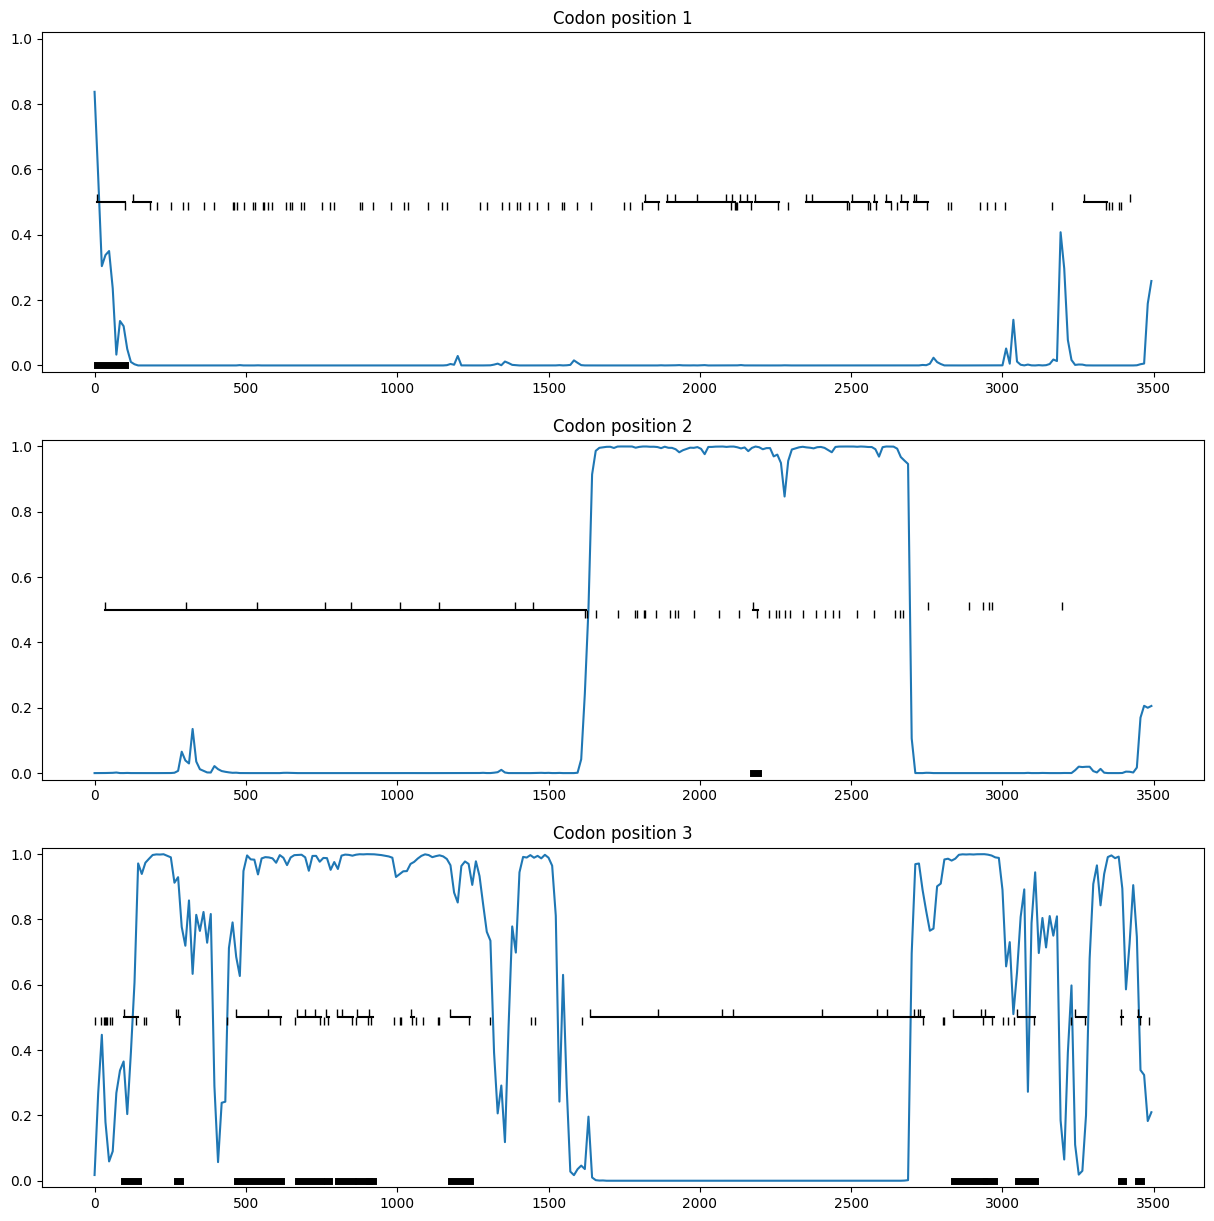


Predicted genes:
[[   9  101    1]
 [2176 2193    2]
 [  98  142    3]
 [ 272  283    3]
 [ 470  616    3]
 [ 671  748    3]
 [ 767  775    3]
 [ 803  853    3]
 [ 869  907    3]
 [ 908  919    3]
 [1178 1240    3]
 [2840 2938    3]
 [2945 2971    3]
 [3050 3109    3]
 [3392 3397    3]
 [3449 3457    3]]


In [18]:
mark1 = GeneMark()
mark1.set_tables(t1,t2)
predicted_genes = mark1.predict(seq, start=0, stop=3500, tol=1e-4, max_iters=1, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### II. Как в основном задании, но с пересчётом таблиц, начиная с данных выше

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-13-7184985b58bd>:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
<ipython-input-13-7184985b58bd>:279: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


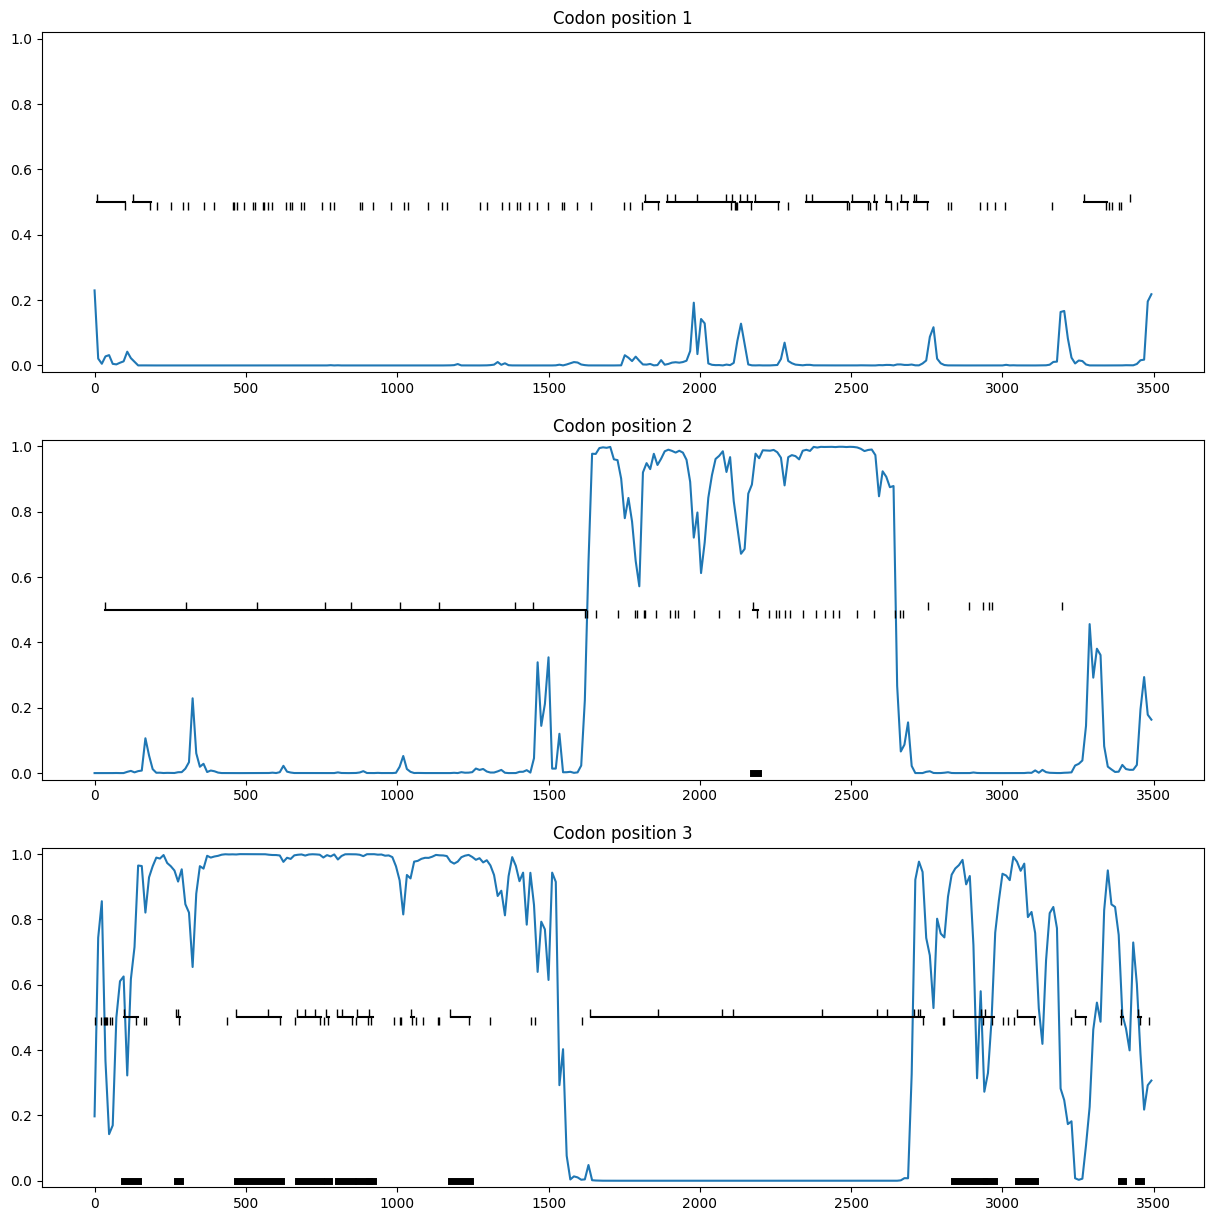


Predicted genes:
[[2176 2193    2]
 [  98  142    3]
 [ 272  283    3]
 [ 470  616    3]
 [ 671  748    3]
 [ 767  775    3]
 [ 803  853    3]
 [ 869  907    3]
 [ 908  919    3]
 [1178 1240    3]
 [2840 2938    3]
 [2945 2971    3]
 [3050 3109    3]
 [3392 3397    3]
 [3449 3457    3]]


In [17]:
mark2 = GeneMark()
mark2.set_tables(t1,t2)
predicted_genes = mark1.predict(seq, start=0, stop=3500, tol=1e-4, max_iters=100, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### III. На этом же участке предскажем гены, расчитывая их из ORF, а не из изначальными таблицами

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-16-7184985b58bd>:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
<ipython-input-16-7184985b58bd>:279: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


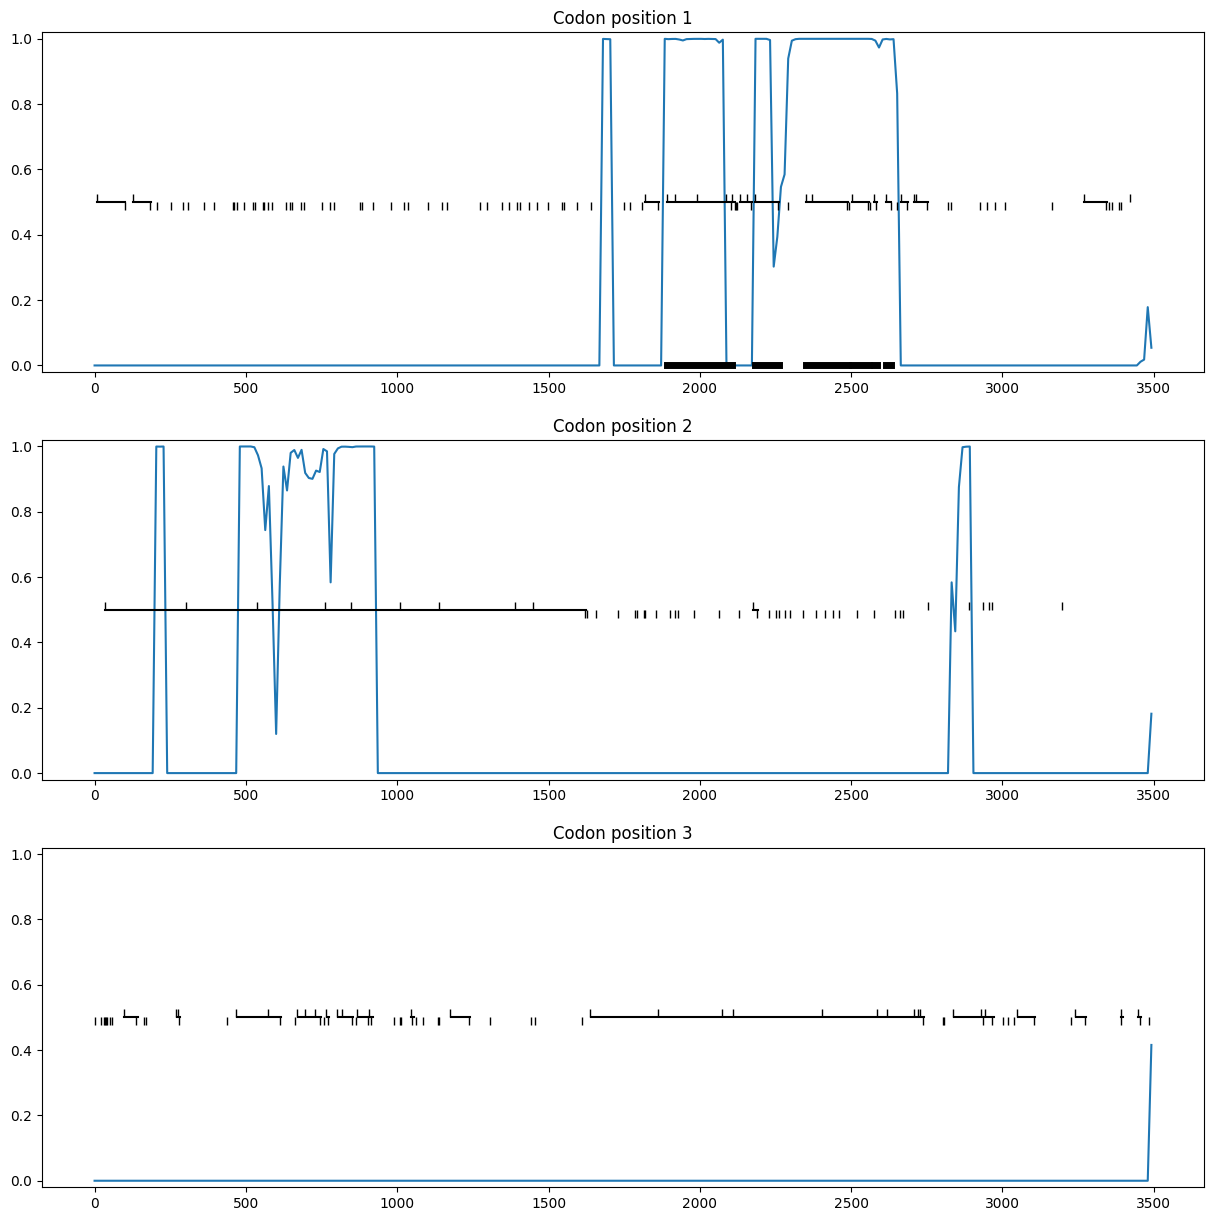


Predicted genes:
[[1890 2105    1]
 [2181 2261    1]
 [2352 2489    1]
 [2502 2558    1]
 [2577 2585    1]
 [2616 2633    1]]


In [19]:
mark3 = GeneMark()
predicted_genes = mark3.predict(seq, start=0, stop=3500, tol=1e-4, max_iters=100, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### IV. Запуск на файле .fasta

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-16-7184985b58bd>:278: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
<ipython-input-16-7184985b58bd>:279: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


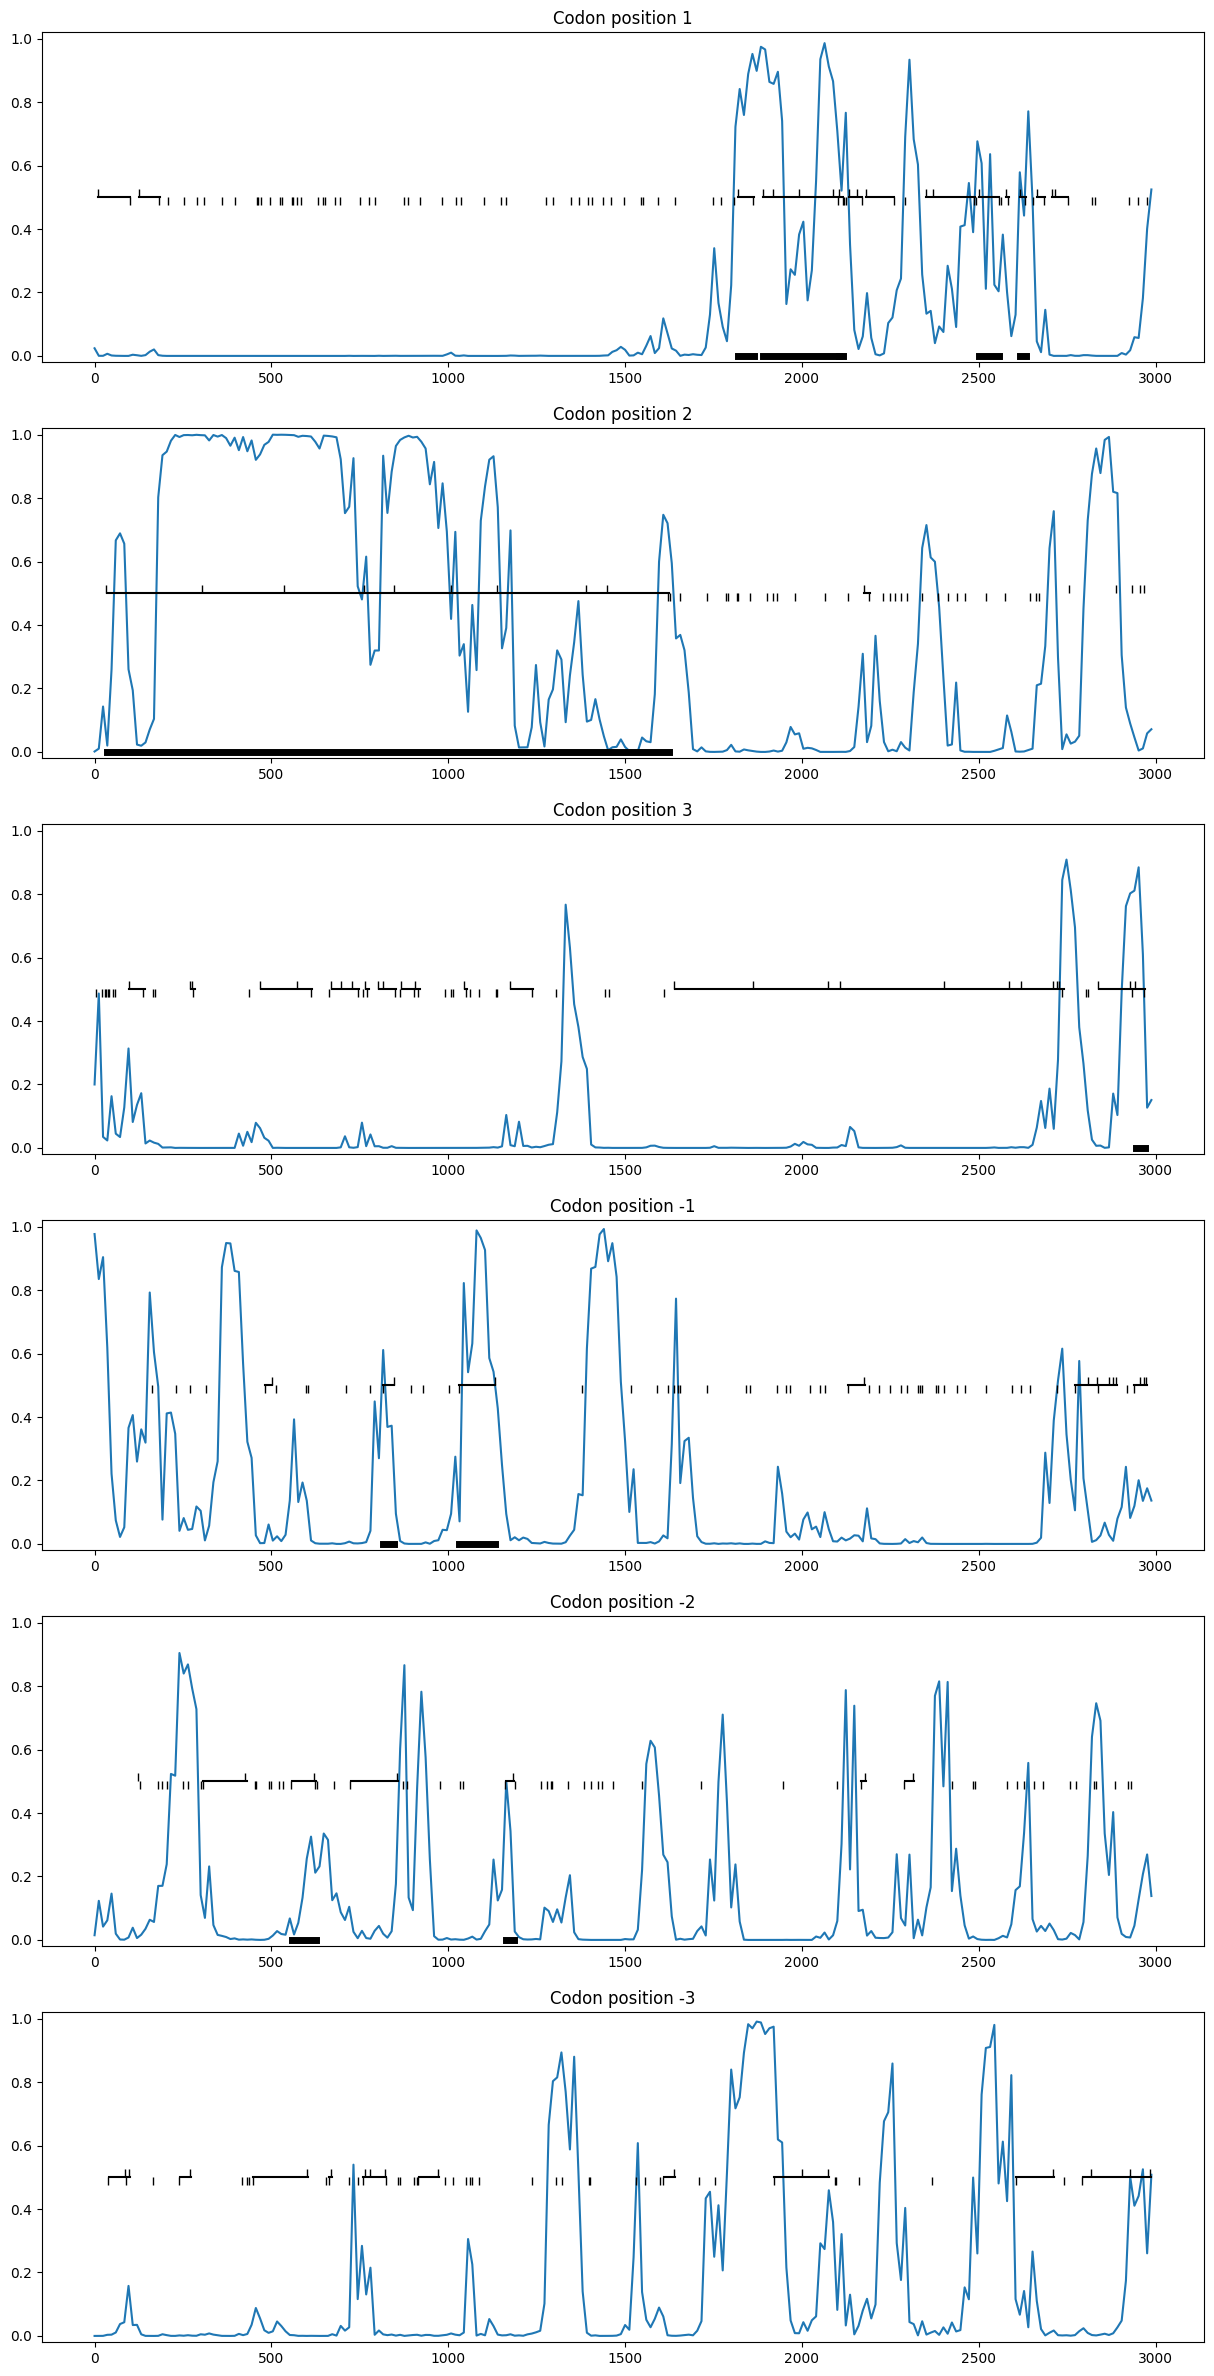


Predicted genes:
[[1818 1865    1]
 [1890 2105    1]
 [2106 2117    1]
 [2502 2558    1]
 [2616 2633    1]
 [  34 1623    2]
 [2945 2971    3]
 [ 816  848   -1]
 [1029 1133   -1]
 [ 557  625   -2]
 [1163 1186   -2]]


In [22]:
mark5 = GeneMark()
predicted_genes = mark5.predict("./GCF_000355675.1_ASM35567v1_genomic.fna", start=0, stop=3000, tol=1e-4, max_iters=10, no_out=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### V. Предсказание полного списка генов

#### Здесь необходимо загрузить в колаб файлы из папки Data:


*   *scaffolds.fasta*
*   *gms2.lst*



#### Подготовка данных

In [26]:
sequencies=[]
names = []
for record in SeqIO.parse("./scaffolds.fasta", "fasta"):
    sequencies.append(record.seq)
    names.append(record.name)

#### Запуск

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/SpryGorgon/hse22_hw2/main/data/gms2.lst

In [27]:
from pprint import pprint
from Bio.SeqFeature import SeqFeature, FeatureLocation

genes = {}

skip=9
with open("gms2.lst") as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines[skip:]]
    reading=False
    buf=[]
    name=''
    for line in lines:
        if(len(line)==0):
            continue
        if(line[0]=='#'):
            if reading:
                if(len(buf)>0):
                    genes[name] = buf.copy()
                reading=False
                name=''
                buf=[]
            else:
                reading=True
            continue
        if(name==''):
            name = line.split()[1]
            continue
        buf.append(line.split())

In [28]:
all_genes = {}
for name,seq in zip(names,sequencies):
    if name not in genes: continue
    try:
        mark6 = GeneMark()
        predicted_genes = mark6.predict(seq, tol=1e-4, max_iters=4, no_out=False, plot=False)
        all_genes[name] = predicted_genes
    except Exception as e:
        all_genes[name]=np.array([])
    finally:
        print(f"Scaffold {name}: \n\t{len(all_genes[name])} genes out of {len(genes[name]) if name in genes.keys() else 0} were predicted\n\t"+\
            f"{len(all_genes[name])/(len(genes[name]))*100}%\n")

  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_1_length_356090_cov_63.781943: 
	3230 genes out of 319 were predicted
	1012.5391849529781%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_2_length_305147_cov_67.132691: 
	2635 genes out of 274 were predicted
	961.6788321167883%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_3_length_263692_cov_64.020194: 
	2149 genes out of 234 were predicted
	918.3760683760684%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_4_length_227396_cov_67.715872: 
	2121 genes out of 219 were predicted
	968.4931506849315%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_5_length_226484_cov_62.611481: 
	1832 genes out of 209 were predicted
	876.555023923445%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_6_length_225246_cov_61.761531: 
	2111 genes out of 212 were predicted
	995.7547169811321%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_7_length_192242_cov_65.503624: 
	1858 genes out of 171 were predicted
	1086.5497076023391%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_8_length_175336_cov_61.514688: 
	1463 genes out of 166 were predicted
	881.3253012048193%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_9_length_169748_cov_65.705038: 
	1530 genes out of 157 were predicted
	974.5222929936306%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_10_length_166246_cov_64.338237: 
	1473 genes out of 173 were predicted
	851.4450867052024%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_11_length_155007_cov_66.930811: 
	1271 genes out of 128 were predicted
	992.96875%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_12_length_149710_cov_70.657018: 
	1205 genes out of 131 were predicted
	919.8473282442749%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_13_length_114910_cov_68.749693: 
	1037 genes out of 108 were predicted
	960.1851851851851%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_14_length_114033_cov_67.102002: 
	982 genes out of 115 were predicted
	853.9130434782609%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_15_length_101551_cov_74.188352: 
	882 genes out of 95 were predicted
	928.421052631579%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_16_length_87688_cov_66.434631: 
	738 genes out of 90 were predicted
	819.9999999999999%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_17_length_87522_cov_68.032561: 
	840 genes out of 75 were predicted
	1120.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_18_length_87172_cov_65.447421: 
	611 genes out of 79 were predicted
	773.4177215189874%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_19_length_84696_cov_64.386999: 
	742 genes out of 71 were predicted
	1045.0704225352113%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_20_length_75280_cov_72.810090: 
	599 genes out of 59 were predicted
	1015.2542372881356%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_21_length_69903_cov_58.377076: 
	673 genes out of 60 were predicted
	1121.6666666666667%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_22_length_68574_cov_56.150207: 
	530 genes out of 56 were predicted
	946.4285714285713%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_23_length_67031_cov_68.890632: 
	619 genes out of 64 were predicted
	967.1875%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_24_length_61824_cov_64.896113: 
	553 genes out of 64 were predicted
	864.0625%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_25_length_52914_cov_71.137649: 
	463 genes out of 49 were predicted
	944.8979591836734%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_26_length_52607_cov_67.959678: 
	468 genes out of 45 were predicted
	1040.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_27_length_27561_cov_70.523086: 
	226 genes out of 19 were predicted
	1189.4736842105265%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_28_length_16969_cov_66.271314: 
	140 genes out of 14 were predicted
	1000.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_29_length_15532_cov_69.573432: 
	81 genes out of 11 were predicted
	736.3636363636364%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_30_length_12326_cov_112.321245: 
	44 genes out of 3 were predicted
	1466.6666666666665%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_31_length_12171_cov_55.131066: 
	118 genes out of 9 were predicted
	1311.111111111111%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_32_length_8704_cov_2.100474: 
	112 genes out of 3 were predicted
	3733.3333333333335%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_34_length_5050_cov_142.283684: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_35_length_3398_cov_68.230033: 
	37 genes out of 5 were predicted
	740.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_37_length_2646_cov_70.868777: 
	2 genes out of 1 were predicted
	200.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_38_length_2391_cov_65.826199: 
	0 genes out of 4 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_39_length_2337_cov_260.985977: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_40_length_2251_cov_2.397996: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_41_length_1994_cov_37.684889: 
	0 genes out of 4 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_42_length_1962_cov_118.234400: 
	0 genes out of 4 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_44_length_1686_cov_2.194359: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_45_length_1576_cov_64.972387: 
	0 genes out of 4 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_46_length_1455_cov_1.931429: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_47_length_1403_cov_1.275964: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_48_length_1316_cov_91.065028: 
	11 genes out of 2 were predicted
	550.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_50_length_1257_cov_145.792013: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_51_length_1251_cov_1.836957: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_52_length_1219_cov_245.118557: 
	1 genes out of 1 were predicted
	100.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_53_length_1091_cov_1.280888: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_54_length_1045_cov_1.136364: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_55_length_1028_cov_1.240493: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_56_length_1020_cov_1.175130: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_57_length_991_cov_1.162393: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_58_length_888_cov_1.644658: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_59_length_866_cov_1.040691: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_60_length_859_cov_1.604478: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_61_length_847_cov_1.295455: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_63_length_839_cov_0.988520: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_64_length_833_cov_1.160668: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_66_length_804_cov_1.321762: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_67_length_792_cov_42.124830: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_69_length_763_cov_0.806497: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_70_length_751_cov_510.396552: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_71_length_747_cov_135.024566: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_76_length_699_cov_75.139752: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_77_length_696_cov_0.870515: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_78_length_691_cov_67.985849: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_79_length_690_cov_113.207874: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_80_length_672_cov_0.779579: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_81_length_663_cov_1.014803: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_82_length_659_cov_1.720199: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_83_length_651_cov_1.357383: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_85_length_583_cov_0.878788: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_86_length_567_cov_1.458984: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_89_length_547_cov_1.032520: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_90_length_506_cov_786.964523: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_91_length_506_cov_1.088692: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_93_length_504_cov_1.269488: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_95_length_499_cov_111.952703: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_96_length_497_cov_83.031674: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_97_length_497_cov_0.859729: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_98_length_487_cov_2.256944: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_99_length_483_cov_1.434579: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_102_length_481_cov_1.002347: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_103_length_476_cov_273.995249: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_104_length_476_cov_1.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_105_length_468_cov_1.116223: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_106_length_466_cov_0.703163: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_107_length_454_cov_1.328321: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_108_length_449_cov_0.857868: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_109_length_445_cov_0.946154: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_110_length_429_cov_0.868984: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_112_length_426_cov_1.409704: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_117_length_415_cov_0.783333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_119_length_412_cov_1.411765: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_120_length_409_cov_1.451977: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_121_length_408_cov_1.359773: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_122_length_404_cov_635.054441: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_123_length_403_cov_0.971264: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_124_length_402_cov_1.772334: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_125_length_396_cov_1.287390: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_127_length_392_cov_1.281899: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_128_length_387_cov_660.554217: 
	3 genes out of 1 were predicted
	300.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_129_length_385_cov_1.293939: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_130_length_377_cov_501.922360: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_131_length_373_cov_1.179245: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_132_length_367_cov_1.365385: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_133_length_367_cov_1.125000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_134_length_364_cov_0.941748: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_136_length_363_cov_0.983766: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_137_length_362_cov_1.403909: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_138_length_361_cov_370.232026: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_139_length_354_cov_66.444816: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_140_length_353_cov_1.127517: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_141_length_352_cov_1.498316: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_142_length_351_cov_167.466216: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_143_length_349_cov_1.340136: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_146_length_339_cov_0.936620: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_147_length_338_cov_1.448763: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_148_length_334_cov_0.767025: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_149_length_331_cov_827.387681: 
	1 genes out of 1 were predicted
	100.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_152_length_322_cov_1.022472: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_153_length_320_cov_1.335849: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_154_length_316_cov_98.678161: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_155_length_315_cov_1.388462: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_156_length_315_cov_1.238462: 
	0 genes out of 2 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_158_length_312_cov_104.922179: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_161_length_306_cov_72.525896: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_162_length_306_cov_0.804781: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_164_length_303_cov_48.487903: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_166_length_296_cov_1.120332: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_167_length_294_cov_1.426778: 
	3 genes out of 1 were predicted
	300.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_168_length_293_cov_158.243697: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_169_length_292_cov_0.907173: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_170_length_291_cov_43.046610: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_171_length_291_cov_40.084746: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_173_length_289_cov_1.243590: 
	2 genes out of 1 were predicted
	200.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_174_length_289_cov_1.038462: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_176_length_283_cov_2.004386: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_178_length_279_cov_1.026786: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_181_length_273_cov_49.073394: 
	2 genes out of 1 were predicted
	200.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_184_length_269_cov_0.934579: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_186_length_267_cov_1.150943: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_187_length_265_cov_2.057143: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_188_length_265_cov_1.571429: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_190_length_261_cov_1.121359: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_191_length_260_cov_1.346341: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_193_length_255_cov_59.370000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_194_length_254_cov_1.150754: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_197_length_247_cov_365.859375: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_198_length_246_cov_386.643979: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_199_length_243_cov_1.994681: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_200_length_243_cov_1.441489: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_203_length_242_cov_0.737968: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_204_length_240_cov_43.335135: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_207_length_234_cov_38.374302: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_213_length_231_cov_600.051136: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_214_length_231_cov_187.215909: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_215_length_231_cov_0.914773: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_217_length_229_cov_1.206897: 
	3 genes out of 1 were predicted
	300.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_218_length_228_cov_267.294798: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_219_length_228_cov_0.913295: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_224_length_224_cov_46.130178: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_228_length_222_cov_35.359281: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_230_length_220_cov_1.109091: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_231_length_219_cov_0.871951: 
	4 genes out of 1 were predicted
	400.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_233_length_217_cov_1.259259: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_234_length_217_cov_0.679012: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_239_length_212_cov_0.777070: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_242_length_210_cov_0.503226: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_244_length_205_cov_23.833333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_245_length_195_cov_104.585714: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_247_length_183_cov_90.695312: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_248_length_177_cov_46.778689: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_249_length_171_cov_39.732759: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_250_length_167_cov_60.535714: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_251_length_162_cov_211.700935: 
	2 genes out of 1 were predicted
	200.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_252_length_157_cov_2.715686: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_253_length_156_cov_227.227723: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_254_length_155_cov_25.560000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_255_length_154_cov_400.050505: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_256_length_146_cov_303.582418: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_257_length_141_cov_183.162791: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_258_length_141_cov_73.383721: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_259_length_140_cov_159.870588: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_260_length_135_cov_69.712500: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_261_length_132_cov_107.584416: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_262_length_132_cov_97.662338: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_264_length_129_cov_186.648649: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_265_length_129_cov_65.229730: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_267_length_126_cov_171.943662: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_268_length_124_cov_155.362319: 
	2 genes out of 1 were predicted
	200.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_269_length_124_cov_0.536232: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_271_length_123_cov_81.029412: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_272_length_121_cov_156.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_273_length_121_cov_63.909091: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_274_length_116_cov_239.557377: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_275_length_115_cov_87.283333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_276_length_113_cov_214.017241: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_277_length_111_cov_212.767857: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_278_length_111_cov_78.892857: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_281_length_109_cov_532.740741: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_284_length_108_cov_75.811321: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_288_length_106_cov_2.313725: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_289_length_104_cov_236.979592: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_291_length_102_cov_1010.340426: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_292_length_102_cov_662.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_293_length_102_cov_122.106383: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_294_length_102_cov_116.191489: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_295_length_101_cov_134.239130: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_298_length_101_cov_19.391304: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_299_length_99_cov_96.545455: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_300_length_99_cov_89.818182: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_301_length_99_cov_28.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_302_length_98_cov_136.697674: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_303_length_98_cov_121.046512: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_304_length_98_cov_117.023256: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_306_length_97_cov_0.571429: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_307_length_96_cov_455.902439: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_311_length_95_cov_61.800000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_312_length_95_cov_37.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_313_length_93_cov_110.289474: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_315_length_92_cov_153.243243: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_316_length_92_cov_51.756757: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_317_length_92_cov_18.972973: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_324_length_87_cov_312.625000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_326_length_87_cov_49.812500: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_328_length_85_cov_942.133333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_330_length_84_cov_48.862069: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_332_length_84_cov_34.379310: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_334_length_82_cov_1028.851852: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_336_length_82_cov_466.074074: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_338_length_80_cov_438.760000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_340_length_80_cov_314.520000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_342_length_80_cov_32.680000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_344_length_80_cov_11.280000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_346_length_76_cov_299.571429: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_348_length_74_cov_842.473684: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_350_length_74_cov_449.157895: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_352_length_74_cov_28.631579: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_354_length_72_cov_72.588235: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_356_length_71_cov_31.812500: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_358_length_70_cov_1126.533333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_360_length_69_cov_11.142857: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_362_length_67_cov_388.750000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_364_length_67_cov_215.583333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_366_length_67_cov_6.083333: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_368_length_66_cov_664.545455: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_370_length_66_cov_201.272727: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_372_length_66_cov_12.727273: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_374_length_64_cov_1260.777778: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_376_length_63_cov_131.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_378_length_63_cov_12.125000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_380_length_62_cov_10.571429: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_382_length_58_cov_664.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_384_length_58_cov_65.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_386_length_57_cov_402.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_388_length_57_cov_292.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_390_length_57_cov_219.000000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_392_length_57_cov_12.500000: 
	0 genes out of 1 were predicted
	0.0%



  0%|          | 0/4 [00:00<?, ?it/s]

Scaffold NODE_394_length_56_cov_90.000000: 
	0 genes out of 1 were predicted
	0.0%



In [29]:
genes['NODE_1_length_356090_cov_63.781943'][:10]

[['1047', '-', '51', '1802', '1752', 'atypical', 'CGGACC', '6', '1'],
 ['1048', '-', '1960', '2847', '888', 'native', 'GGGAGA', '7', '1'],
 ['1049', '+', '3020', '4648', '1629', 'native', 'AGGACA', '9', '1'],
 ['1050', '+', '4918', '7005', '2088', 'native', 'AGGAAA', '6', '1'],
 ['1051', '+', '7072', '7341', '270', 'native', 'AGGAGC', '2', '1'],
 ['1052', '+', '7805', '8446', '642', 'native', 'AGGATA', '5', '1'],
 ['1053', '+', '8446', '9303', '858', 'native', 'CGGTAA', '4', '1'],
 ['1054', '+', '9493', '9867', '375', 'native', 'AGGTGA', '2', '1'],
 ['1055', '+', '10057', '10533', '477', 'native', 'AGGATG', '5', '1'],
 ['1056', '-', '10537', '11655', '1119', 'native', 'TGGATC', '5', '1']]

In [30]:
all_genes['NODE_1_length_356090_cov_63.781943'][:10]

array([[ 480, 1142,    1],
       [1143, 1847,    1],
       [1914, 1943,    1],
       [2013, 2039,    1],
       [2085, 2099,    1],
       [2640, 2666,    1],
       [4137, 4547,    1],
       [6333, 6359,    1],
       [7533, 7586,    1],
       [7596, 7763,    1]])